In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import*
from fastai.dataset import*

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
PATH = Path('../data/pascal_2007')
list(PATH.iterdir())

[PosixPath('../data/pascal_2007/train'),
 PosixPath('../data/pascal_2007/test'),
 PosixPath('../data/pascal_2007/test.csv'),
 PosixPath('../data/pascal_2007/train.csv'),
 PosixPath('../data/pascal_2007/train.json'),
 PosixPath('../data/pascal_2007/test.json'),
 PosixPath('../data/pascal_2007/segmentation'),
 PosixPath('../data/pascal_2007/valid.json')]

In [4]:
trn_j = json.load((PATH/'train.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [6]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [7]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

In [8]:
FILENAME, ID, IMG_ID, CAT_ID,BBOX = 'file_name', 'id', 'image_id','category_id', 'bbox'

In [9]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILENAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]] 

In [10]:
IMG_PATH = Path('../data/pascal_2007/train')
list(IMG_PATH.iterdir())[:5]

[PosixPath('../data/pascal_2007/train/002470.jpg'),
 PosixPath('../data/pascal_2007/train/006950.jpg'),
 PosixPath('../data/pascal_2007/train/009732.jpg'),
 PosixPath('../data/pascal_2007/train/000492.jpg'),
 PosixPath('../data/pascal_2007/train/002083.jpg')]

In [11]:
im0_d = trn_j[IMAGES][0]
im0_d[FILENAME], im0_d[ID]

('000012.jpg', 12)

In [12]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
        
len(trn_anno)

2501

In [13]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [34]:
im0_a = im_a[0];im0_a

(array([ 96, 155, 269, 350]), 7)

In [14]:
cats[7]

'car'

In [48]:
trn_anno[17]
list(trn_anno)[:5]

[12, 17, 23, 26, 32]

In [16]:
cats[15],cats[13]

('person', 'horse')

In [17]:

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [18]:
im = open_image(IMG_PATH/im0_d[FILENAME])

In [28]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [29]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [30]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [31]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

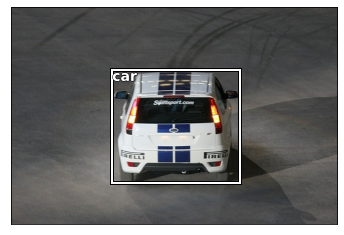

In [35]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [36]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [37]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(281, 500, 3)


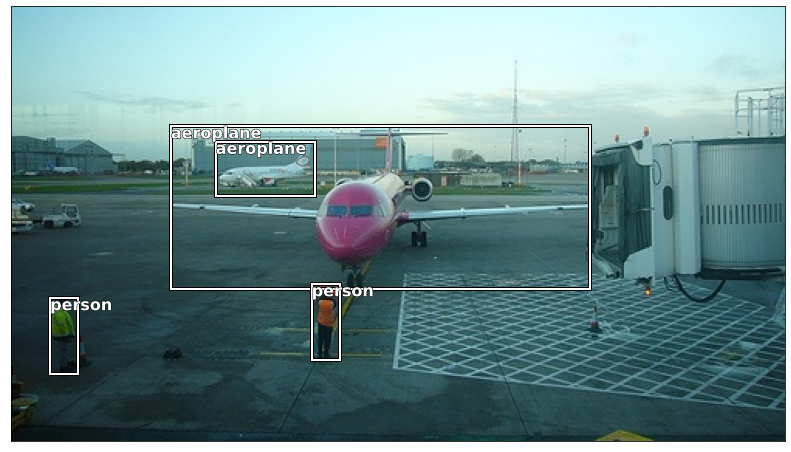

In [52]:
draw_idx(32)

### Step 1. Largest item classifier